In [13]:
import pandas as pd
import numpy as np

Split in categorical and numerical variables

In [14]:
df=pd.read_csv('datasets/train_table.csv',low_memory=False,index_col='ID')

y=df['attrition']
X=df.drop(columns='attrition')

# Create a DataFrame with numeric columns
X_numeric = X.select_dtypes(include=['number'])

# Create a DataFrame with object (categorical) columns
X_categorical = X.select_dtypes(include=['object'])


In [15]:
from sklearn.base import BaseEstimator,TransformerMixin
class SelectCatColumns (BaseEstimator,TransformerMixin):
    def __init__(self,list_columns):
        self.list_columns=list_columns
    def fit(self,X,y=None):
        return self
    def transform (self,X):
        return X[self.list_columns]

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

num_cols=X_numeric.columns.tolist()
cat_cols=X_categorical.columns.tolist()

In [17]:
flag_cat=X_categorical.describe().T
flag_cat['ratio']=flag_cat['freq']/flag_cat['count']
flag_cat['flag_delete']=np.where(flag_cat['ratio']>0.7,1,0)

In [18]:
col_st=flag_cat.loc[flag_cat['flag_delete']==0].index.to_list()

In [19]:
col_st

['product', 'entity', 'period', 'type_job', 'bureau_risk', 'product_1']

In [20]:
df_categorical=X_categorical[col_st]#.describe().T

In [21]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler,MinMaxScaler
from sklearn.pipeline import Pipeline

# pipecat=Pipeline([('feature',SelectCatColumns(col_st)),
#                   ('encoding',OneHotEncoder(handle_unknown='ignore',sparse=False,sparse_output=False).set_output(transform='pandas'))])

# Supongamos que tienes un DataFrame llamado 'data' con las columnas que deseas transformar

# Definir las columnas categóricas y numéricas
categorical_columns = ['product', 'entity', 'period', 'type_job', 'bureau_risk', 'product_1']
numeric_columns = num_cols  # Agrega tus columnas numéricas aquí

# Crear un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num','passthrough', numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore',sparse=False,sparse_output=False).set_output(transform='pandas'), categorical_columns),
    ],
    remainder='drop',
    n_jobs=-1
)

# Aplicar la transformación y configurar la salida en formato Pandas
preprocessor.set_output(transform='pandas')
X_tr = preprocessor.fit_transform(X)

# Ahora, data_transformed contendrá las columnas transformadas con one-hot encoding y StandardScaler en formato Pandas


In [ ]:
#Feature Engineering
class Feature_creation(BaseEstimator, TransformerMixin):
    def __init__(self, mean_balance_amount = None, total_outcome = None,outcome_ratio = None,saving_ratio = None):
        self.feature_methods = [
            ('create_mean_balance_amount', mean_balance_amount),
            ('create_total_outcome', total_outcome),
            ('create_outcome_ratio', outcome_ratio),
            ('create_saving_ratio', saving_ratio),
        ]
        
        
    def create_mean_balance_amount(self, X):
        X['mean_balance_amount'] = X['num__balance_amount']/X['num__month']
        X['mean_balance_amount']=X['mean_balance_amount'].fillna(0)
        X['mean_balance_amount']=X['mean_balance_amount'].replace([np.inf,-np.inf],0)
        return X
    
    def create_total_outcome(self, X):
        X['total_outcome'] = (X['num__type_1']+X['num__type_2']+X['num__type_3']+X['num__type_4'])/X['num__month']
        X['total_outcome']=X['total_outcome'].fillna(0)
        X['total_outcome']=X['total_outcome'].replace([np.inf,-np.inf],0)
        return X
    
    def create_outcome_ratio(self, X):
        X['outcome_ratio'] = (X['num__type_1']+X['num__type_2']+X['num__type_3']+X['num__type_4'])/X['num__income']
        X['outcome_ratio']=X['outcome_ratio'].fillna(0)
        X['outcome_ratio']=X['outcome_ratio'].replace([np.inf,-np.inf],0)
        return X
    
    def create_saving_ratio(self, X):
        X['saving_ratio'] = X['num__product_1_lia']/X['num__income']
        X['saving_ratio']=X['saving_ratio'].fillna(0)
        X['saving_ratio']=X['saving_ratio'].replace([np.inf,-np.inf],0)
        return X

  
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        for method_name, apply_method in self.feature_methods:
            if apply_method:
                method = getattr(self, method_name)
                X = method(X)
        return X

In [26]:
# Creating a bunch of features so that we will discard some of them afterwards
feature_creator = Feature_creation(mean_balance_amount = True, 
                                   total_outcome = True,  
                                   outcome_ratio = True,
                                   saving_ratio = True)
clients_db = feature_creator.transform(X_tr)

In [ ]:
#Feature Importance
class Feature_importance(BaseEstimator, TransformerMixin):
    def __init__(self, white_noise = None, f_importance = None):
        self.feature_methods = [
            ('create_white_noise', white_noise),
            ('create_feature_importance', f_importance)
        ]
        
    def create_white_noise(self, X):
        np.random.seed(42)  
        nueva_columna = np.random.randint(2, size=len(X))
        X['ruido'] = nueva_columna
        return X
    
    def create_feature_importance(self, X):
        import seaborn as sns
        import matplotlib.pyplot as plt
        from sklearn.ensemble import RandomForestClassifier

        modelo_rf = RandomForestClassifier(n_estimators=50,class_weight='balanced', random_state=42,max_depth=5)

        
        modelo_rf.fit(X_tr,y)

        importancia_caracteristicas=modelo_rf.feature_importances_


        importancia_df=pd.DataFrame({'Caracteristica':X_tr.columns,'importancia':importancia_caracteristicas})
        importancia_df=importancia_df.sort_values(by='importancia',ascending=False)
        return X
    
    

    
  
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        for method_name, apply_method in self.feature_methods:
            if apply_method:
                method = getattr(self, method_name)
                X = method(X)
        return X

In [41]:
#RUIDO BLANCO


In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

modelo_rf = RandomForestClassifier(n_estimators=50,class_weight='balanced', random_state=42,max_depth=5)

X_tr=X_tr.astype('float32')
X_tr=X_tr.fillna(0)
X_tr=X_tr.replace([np.inf,-np.inf],0)
modelo_rf.fit(X_tr,y)

importancia_caracteristicas=modelo_rf.feature_importances_


importancia_df=pd.DataFrame({'Caracteristica':X_tr.columns,'importancia':importancia_caracteristicas})
importancia_df=importancia_df.sort_values(by='importancia',ascending=False)

In [51]:
import pandas as pd

# Supongamos que tienes un DataFrame llamado importancia_df con una columna 'importancia'
# Ordena el DataFrame por la columna 'importancia' en orden descendente
importancia_df = importancia_df.sort_values('importancia', ascending=False)

# Calcula la suma acumulativa de la columna 'importancia'
importancia_df['cumulative_sum'] = importancia_df['importancia'].cumsum()

# Filtra las filas donde la suma acumulativa es al menos el 90% del total
umbral = 0.8  # 90%
importancia_filtrada = importancia_df[importancia_df['cumulative_sum'] <= umbral]

# Elimina la columna 'cumulative_sum' si no la necesitas
importancia_filtrada = importancia_filtrada.drop(columns=['cumulative_sum'])

# Ahora 'importancia_filtrada' contiene las filas que suman al menos el 90% de la importancia total
importancia_filtrada

,Caracteristica,importancia
58,cat__product_1_No,0.220863
59,cat__product_1_Yes,0.205401
11,num__product_1_lia,0.088018
63,saving_ratio,0.080303
8,num__dig_9,0.044094
9,num__dig_10,0.040073
23,num__payroll,0.035597
56,cat__bureau_risk_category_8,0.035013
6,num__dig_7,0.033249


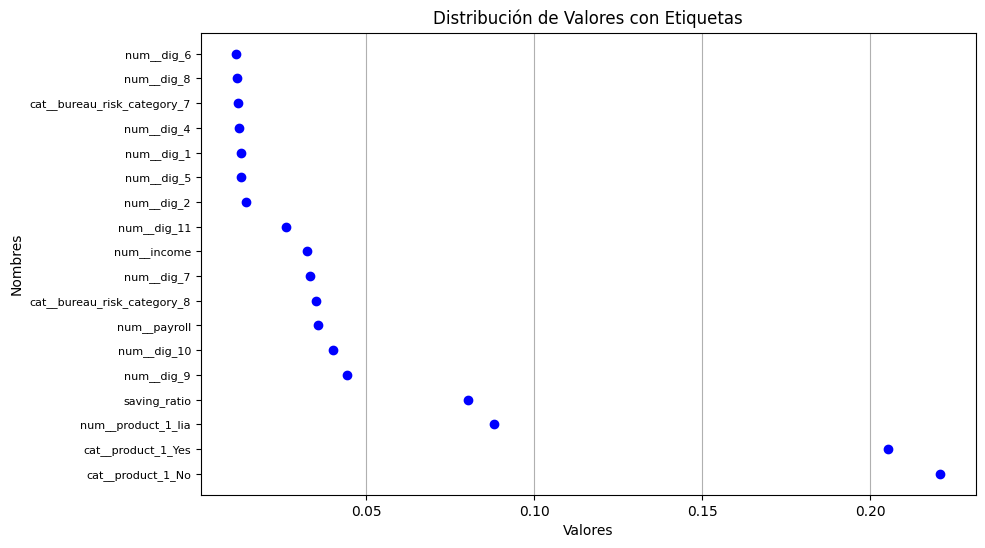

In [47]:
import matplotlib.pyplot as plt

# Supongamos que tienes un DataFrame df con columnas 'nombres' y 'valores'
df_filtrado = importancia_df[importancia_df['importancia'] > 0.01]



# Crear un gráfico de dispersión con etiquetas
plt.figure(figsize=(10, 6))
plt.scatter(df_filtrado['importancia'], range(len(df_filtrado)), marker='o', c='blue')
plt.yticks(range(len(df_filtrado)), df_filtrado['Caracteristica'], fontsize=8)
plt.title('Distribución de Valores con Etiquetas')
plt.xlabel('Valores')
plt.ylabel('Nombres')
plt.grid(axis='x')  # Agregar una cuadrícula en el eje x
plt.show()




In [ ]:
#from sklearn.decomposition import PCA

#pca=PCA(random_state=23)
#pca.fit(X_tr,y)

In [ ]:
#import matplotlib.pyplot as plt
#cum_variance=np.cumsum(pca.explained_variance_ratio_)
#x_axis=range(1,X_tr.shape[1]+1)
#plt.plot(x_axis,cum_variance,'sb-')
##plt.xticks(range(0,X_tr.shape[0]),x_axis)
#threshold=0.90
#plt.axhline(y=threshold,color='r')
#npca=len(cum_variance[cum_variance<threshold])
#print(npca)


In [ ]:
#y.value_counts()/len(y)

In [ ]:
from sklearn.model_selection import StratifiedKFold,cross_validate,RandomizedSearchCV
from sklearn.metrics import make_scorer,f1_score
from lightgbm import LGBMClassifier


skf=StratifiedKFold(n_splits=10,random_state=23,shuffle=True)
custom_f1score=make_scorer(f1_score,average='macro',zero_division=0)
pca=PCA(n_components=npca,random_state=23)
estimator=LGBMClassifier(random_state=23,n_jobs=1
                         ,class_weight='balanced')
model_pipe=Pipeline([('prep',preprocessor),
                     ('pca',pca),
                     ('clf',estimator)])

num_leaves=[10,31,40,50]
max_depth=[5,7,9,11,13,15,20]
n_estimators=[100,150,180,200,250,300]
learning_rate=[0.1,0.01]
boosting_type=['gbdt','dart','rf']

param_grid={'clf__num_leaves':num_leaves,
            'clf__max_depth':max_depth,
            'clf__n_estimators':n_estimators,
            'clf__learning_rate':learning_rate,
            'clf__boosting_type':boosting_type}

model_search=RandomizedSearchCV(estimator=model_pipe,
                                param_distributions=param_grid,
                                random_state=23,
                                n_iter=15,
                                scoring=custom_f1score,
                                cv=skf,
                                error_score=0,
                                return_train_score=True,
                                verbose=2,
                                n_jobs=1)

result_cv=cross_validate(X=X,
                         y=y,
                         estimator=model_search,
                         cv=skf,
                         scoring=custom_f1score,
                         return_train_score=True,
                         return_estimator=True,
                         n_jobs=2,
                         error_score=0)